In [118]:
# Import required packages

#!pip install neo4j

import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
from neo4j import GraphDatabase, basic_auth

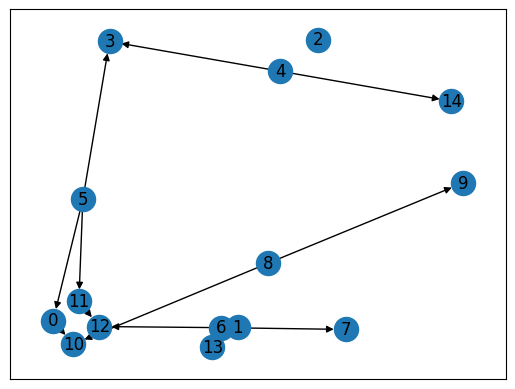

In [119]:
# Create and draw graph

n = 15
p = 0.05

G = nx.erdos_renyi_graph(n, p, directed = True)


nx.draw_networkx(G, with_labels = True)
plt.show()

In [120]:
# Adjust graph so there are no 0 in degree nodes (adding edges that aren't loops)

for deg in G.in_degree():
  if deg[1] == 0:
    out_neighbor = random.randint(0,n)
    while out_neighbor == deg[0]:
      out_neighbor = random.randint(0,n)
    G.add_edge(deg[0],out_neighbor)
    print("something happened")


something happened
something happened
something happened
something happened


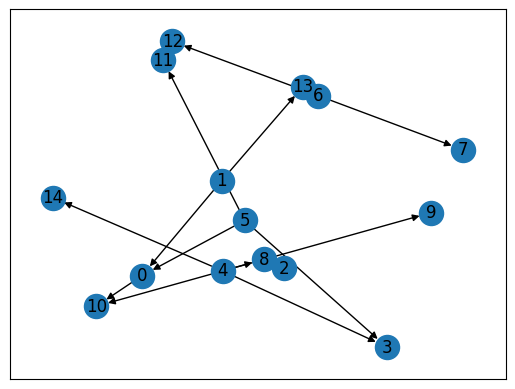

In [121]:
# Draw graph to see that edges have been added

nx.draw_networkx(G, with_labels = True)
plt.show()

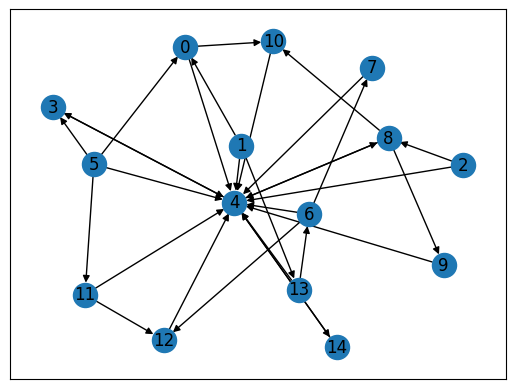

In [122]:
# Simulate home button by adding edges and draw graph again

out_degs = []

for deg in G.out_degree():
  out_degs.append(deg[1])

home = out_degs.index(max(out_degs))

for node in range(n):
  if node != home:
    G.add_edge(node, home)

nx.draw_networkx(G, with_labels = True)
plt.show()

In [123]:
# perform random walks in graph

def random_walk(graph:nx.Graph, start_node:int = 0, walk_length:int = 1) -> list[int]:

    sequence = [start_node]

    for _ in range(walk_length):
        neighbours = [neighbour for neighbour in graph.neighbors(start_node)]
        if neighbours == []:
          return sequence
        selected_neighbour = random.choice(neighbours)
        sequence.append(selected_neighbour)
        start_node = selected_neighbour

    return sequence

In [124]:
# example of random walks in graph

walk_length_max = 6
amount_of_visitors = 1000

# for _ in range(10):
#    print(random_walk(G, random.randrange(n), random.randrange(0, walk_length_max)))

# Simulating visitor behavior

visits = []
fraction_of_visits_through_home = 10 # every i-th user entering through home page

for visit in range(amount_of_visitors):
  if visit % fraction_of_visits_through_home == 0:
    visits.append(random_walk(G, home, random.randrange(0, walk_length_max)))
  else:
    visits.append(random_walk(G, random.randrange(n), random.randrange(0, walk_length_max)))

# Count amount of users taking the same path (path at least of length 2)

path_dict = {}

for visit in visits:
  if len(visit) > 1:
    if tuple(visit) in path_dict:
      path_dict[tuple(visit)] += 1
    else:
      path_dict[tuple(visit)] = 1


# Disregard neglegible traffic:

neglegible_traffic_threshold = 5

filtered_path_dict = {}

for item in path_dict.items():
  if item[1] > neglegible_traffic_threshold:
    filtered_path_dict[item[0]] = item[1]

print(filtered_path_dict)

{(4, 3, 4): 12, (12, 4): 16, (14, 4): 12, (9, 4, 3, 4): 6, (9, 4): 14, (8, 4): 6, (13, 6, 4): 6, (7, 4): 10, (6, 7): 6, (4, 8, 9): 6, (4, 14, 4): 8, (0, 10, 4): 7, (2, 8): 6, (4, 14): 6, (3, 4): 10, (0, 10): 7, (14, 4, 3): 6, (13, 6): 7, (10, 4, 14, 4): 6, (10, 4): 9, (3, 4, 3): 6, (11, 12, 4): 6}


In [125]:
# Import into Neo4j

# Adjust URI and AUTH to personal Neo4j instance
#
# URI = "<URI for Neo4j database>"
# AUTH = ("<Username>", "<Password>")

URI = "bolt://3.215.117.167:7687"
with open("neo4j_auth.txt", 'r') as lines:
  content = lines.read().strip()
  AUTH = tuple(content.split(','))

# create nodes (faster if exported to graphml and imported into Neo4j or using nxneo4j)

def clear_graph_tx(tx):
  tx.run("MATCH (n) DETACH DELETE n")

def create_node_tx(tx, id):
  tx.run("CREATE (n:Node {id: $id})", id = id)

def create_edge_tx(tx, id1, id2, path_start, path_end, users):
  tx.run("MATCH (x:Node{id: $id1}), (y:Node{id: $id2}) MERGE (x)-[r:TRAFFIC{start: $start, end: $end, users: $users}]->(y)", id1 = id1, id2 = id2, start = path_start, end = path_end, users = users)



with GraphDatabase.driver(URI, auth=AUTH) as driver:
  with driver.session(database="neo4j") as session:
    session.execute_write(clear_graph_tx)
    for node in range(n):
      session.execute_write(create_node_tx, node)
    for path, users in filtered_path_dict.items():
      for start_index in range(len(path)-1):
        end_index = start_index + 1
        session.execute_write(create_edge_tx, path[start_index], path[end_index], path[0], path[-1], users)
